# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [51]:
# IPython magic to reload changes on external files
%load_ext autoreload
%autoreload 2

# Import general libs
import numpy as np
import pandas as pd
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from IPython.display import Image

# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from request_utils import *
from transducive_learning_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
display(HTML("""
<style type="text/css">
div.output_png {
  display: flex;
  justify-content: center;
  margin-right:10%;
}
</style>
"""))

## Load processed data

In [3]:
votes = pd.read_pickle("data/processed/processed_votes.pickle")
print("\n\n\nThe vote dataframe is a " + str(votes.shape) + " table with senators as rows and vote positions as columns.")
display(votes.head(3))

# Bill descriptions
bill_descriptions = pd.read_csv("data/processed/processed_bill_descriptions.csv").set_index('bill_id')
display(bill_descriptions.head(3))

# Separate votes into "train" and "test" samples on a 80-20 basis
np.random.seed(2018)
votes_train, votes_test = split_dataframe(0.80, votes)

senators = pd.read_pickle("data/processed/processed_senators.pickle")
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

senators_party = senators['party']
numerical_labels = np.vectorize({'R':0.,'D':0.12,'I':0.223}.get)(senators_party)




The vote dataframe is a (105, 104) table with senators as rows and vote positions as columns.


id,hconres71-115-224-1,hconres71-115-227-1,hconres71-115-231-1,hconres71-115-234-1,hjres38-115-43-1,hr1-115-285-1,hr1-115-286-1,hr1-115-287-1,hr1-115-288-1,hr1-115-289-1,...,sconres3-115-22-1,sconres3-115-23-1,sconres3-115-24-1,sconres3-115-25-1,sconres3-115-4-1,sconres3-115-5-1,sconres3-115-6-1,sconres3-115-7-1,sconres3-115-8-1,sconres3-115-9-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
B000575,0.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
B000944,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0


,summary,summary_short
bill_id,,
hr695-115,NaN,NaN
pn2209-115,NaN,NaN
s756-115,Save Our Seas Act of 2017 or the SOS Act of 20...,Save Our Seas Act of 2017 or the SOS Act of 20...





The senators dataframe is a (105, 4) table with senators as rows and ID, party and names as columns.


,party,first_name,last_name,name
member_id,,,,
A000360,R,Lamar,Alexander,Lamar Alexander
B000575,R,Roy,Blunt,Roy Blunt
B000944,D,Sherrod,Brown,Sherrod Brown


## Load labels

## Building the similarity graph

In [4]:
features = [votes_train.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg, 15),0.5)]

# Builds the adjacency matrix by computing the similarities between senators.
# This implementation can be used to feed various features matrices and apply a different distance function and
# sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features.
adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)

G = graphs.Graph(adjacency)
G = reduction.graph_sparsify(G, 0.25)
G.compute_differential_operator()
G.compute_fourier_basis()
G.compute_laplacian()

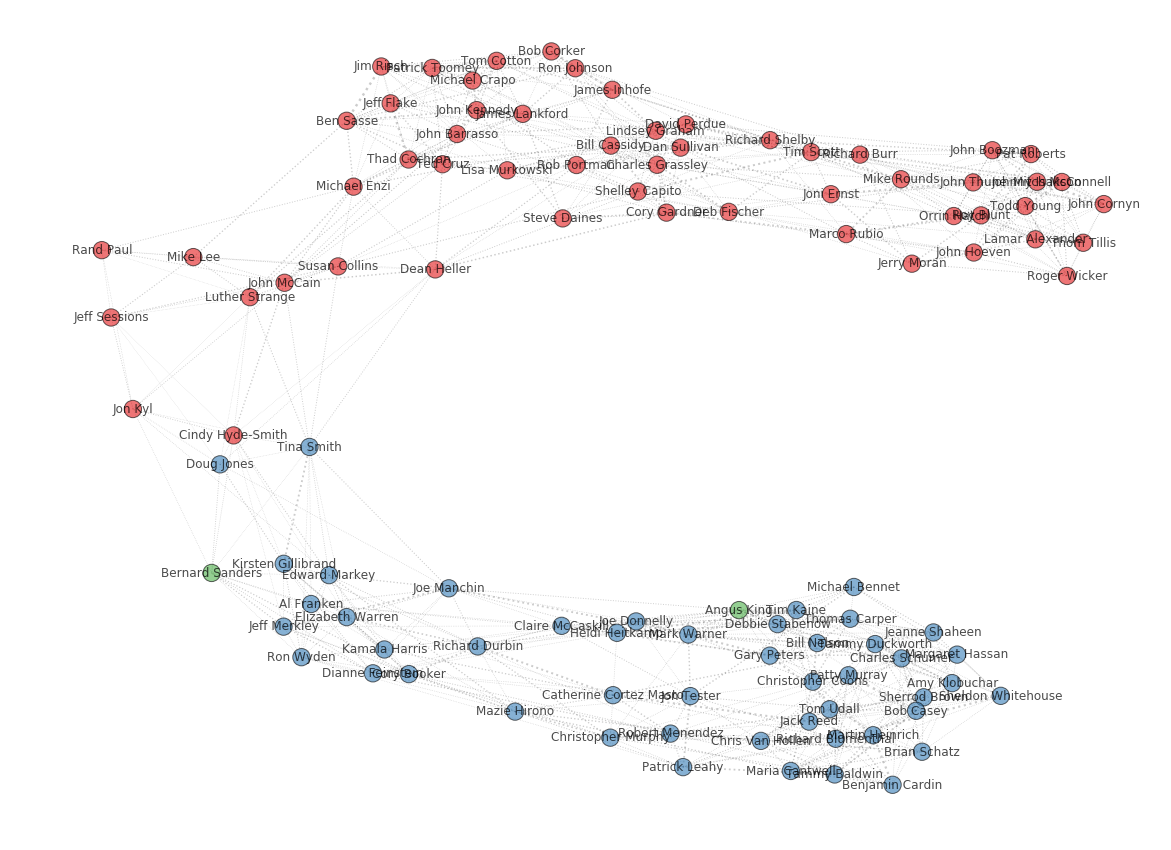

In [5]:
plot_signal(G.W.todense(), numerical_labels, labels=senators['name'], scale=[0,1])

## Clustering the bills

Building a similarity graph where node correspond to bills and features to senators, we can identify which bills are similar in terms of voting base. Therefore, each cluster should then correspond to a different electoral support.

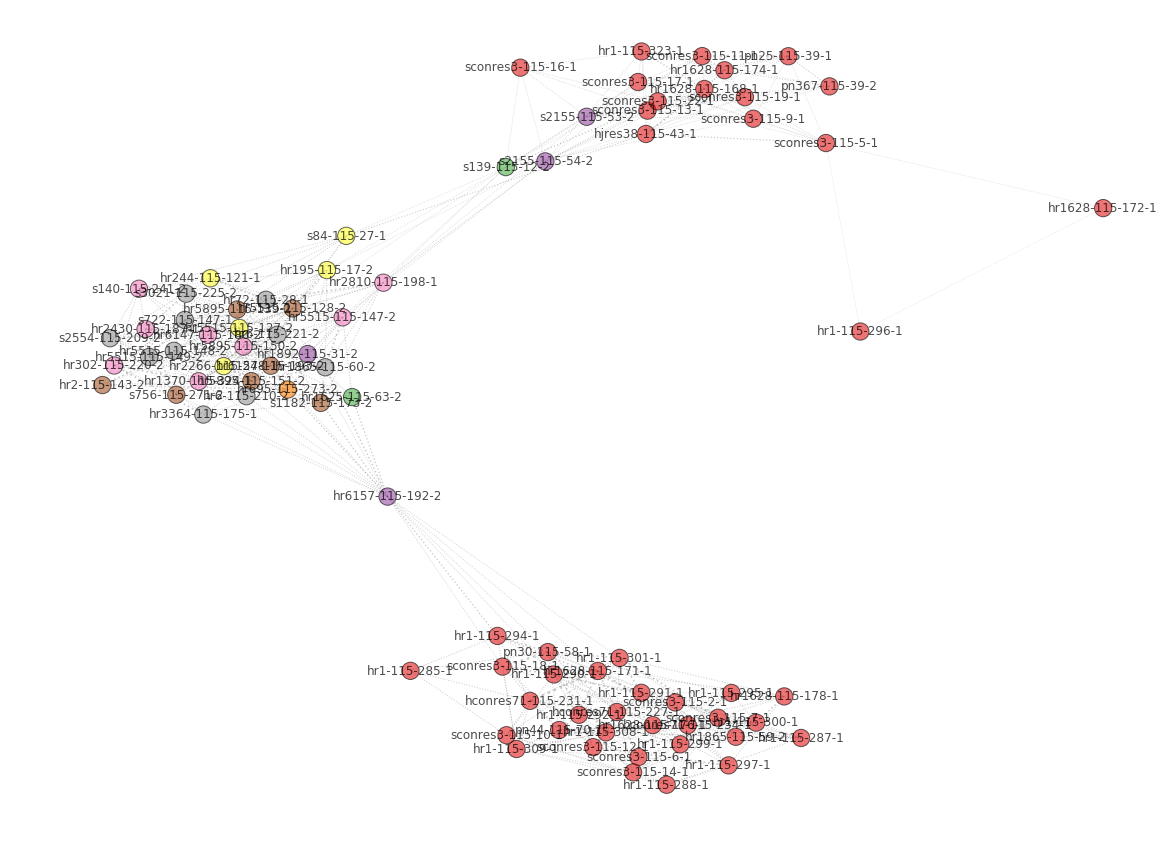

In [6]:
bill_cluster_count = 3

features_bills = [votes_train.T.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(arg,0.7)]
adjacency_bills = get_adjacency_multidistance(features_bills, weights, cosine_similarity, lambda x:x, sparsification_functions)

G_bills = graphs.Graph(adjacency_bills)
G_bills = reduction.graph_sparsify(G_bills,0.33)

plot_signal(G_bills.W.todense(), votes_train.sum(0) / votes_train.shape[0], labels=votes_train.T.index, scale=[0,1])

### Method 1: Get biggest Variance

In [7]:
var = np.zeros(votes_train.shape[1])

for i in range(votes_train.shape[1]):
    a = votes_train.values[:,i]
    var[i] = np.var(a[a != 0])
    
best_bills = var.argsort()[-bill_cluster_count:]
best_bills

array([59, 20, 61], dtype=int64)

### Method 2: Get smallest number of neighbors

In [8]:
temp = adjacency_bills.copy()
temp[temp > 0] = 1
best_bills = temp.sum(0).argsort()[:bill_cluster_count]
best_bills

array([ 1, 40, 23], dtype=int64)

### Method 3: Get closest points of the centers of the cluster of the Bills

In [9]:
G_bills.compute_laplacian()
G_bills.compute_fourier_basis()

embedding = G_bills.U[:,1:1+bill_cluster_count]
clusters, centers = gen_kmeans(embedding, bill_cluster_count)
vote_repr = np.zeros(bill_cluster_count)

for j in range(bill_cluster_count):
    min_ = 1000;
    for i in range(embedding.shape[0]):
        dist = np.linalg.norm(embedding[i] - centers[j])
        if dist < min_:
            min_ = dist
            vote_repr[j] = i
            
vote_repr

array([66., 18.,  1.])

### Getting selected bill description

In [10]:
selected_votes_unique_ids = votes_train.iloc[:, vote_repr].columns.values
for v in selected_votes_unique_ids:
    print_info(v)

============== INFORMATION REGARDING s84-115-27-1 ============== 

Roll call: 27
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00027

RELATED BILL INFORMATION

Bill title: A bill to provide for an exception to a limitation against appointment of persons as Secretary of Defense within seven years of relief from active duty as a regular commissioned officer of the Armed Forces.

Bill url:  https://www.govtrack.us/congress/bills/115/s84

Short description: (This measure has not been amended since it was introduced. The expanded summary of the Senate passed version is repeated here.) (Sec. 1) This bill allows the first person, and only such person, appointed as Secretary of Defense after the enactment of this bill to be a person who is, on the date of appointment, not within at least three years after relief from active duty as a commissioned officer of a regular component of the Armed Forces. (Under current law, an in

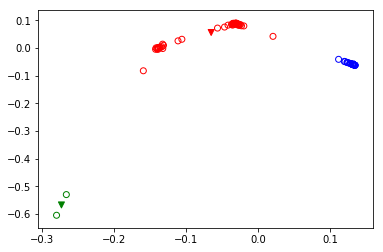

In [11]:
n = len(embedding)
colors = {0:'red',1:'blue',2:'green', 3:'orange'}

for i in range(n-1):
    plt.scatter(embedding[i,0], embedding[i,1], facecolors='none', edgecolors=colors[clusters[i]])
    
plt.scatter(centers[:,0], centers[:,1], marker='v', color=list(colors.values()))

### Method 4: Get the bills with biggest intracluster std

In [12]:
var = np.zeros(votes_train.shape[1])
rep_indexes = np.nonzero(numerical_labels == 0)[0]
dem_indexes = np.nonzero(numerical_labels == 0.12)[0] 
rep_data = votes.iloc[rep_indexes]
dem_data = votes.iloc[dem_indexes]
rep_std = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,rep_data.values)
dem_data = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,dem_data.values)
stds = (rep_std+dem_data)/2

best_bills = stds.argsort()[-bill_cluster_count:]
best_bills

array([15, 29, 39], dtype=int64)

## Vote selection

['s84-115-27-1' 'hconres71-115-231-1' 'hr1628-115-172-1']


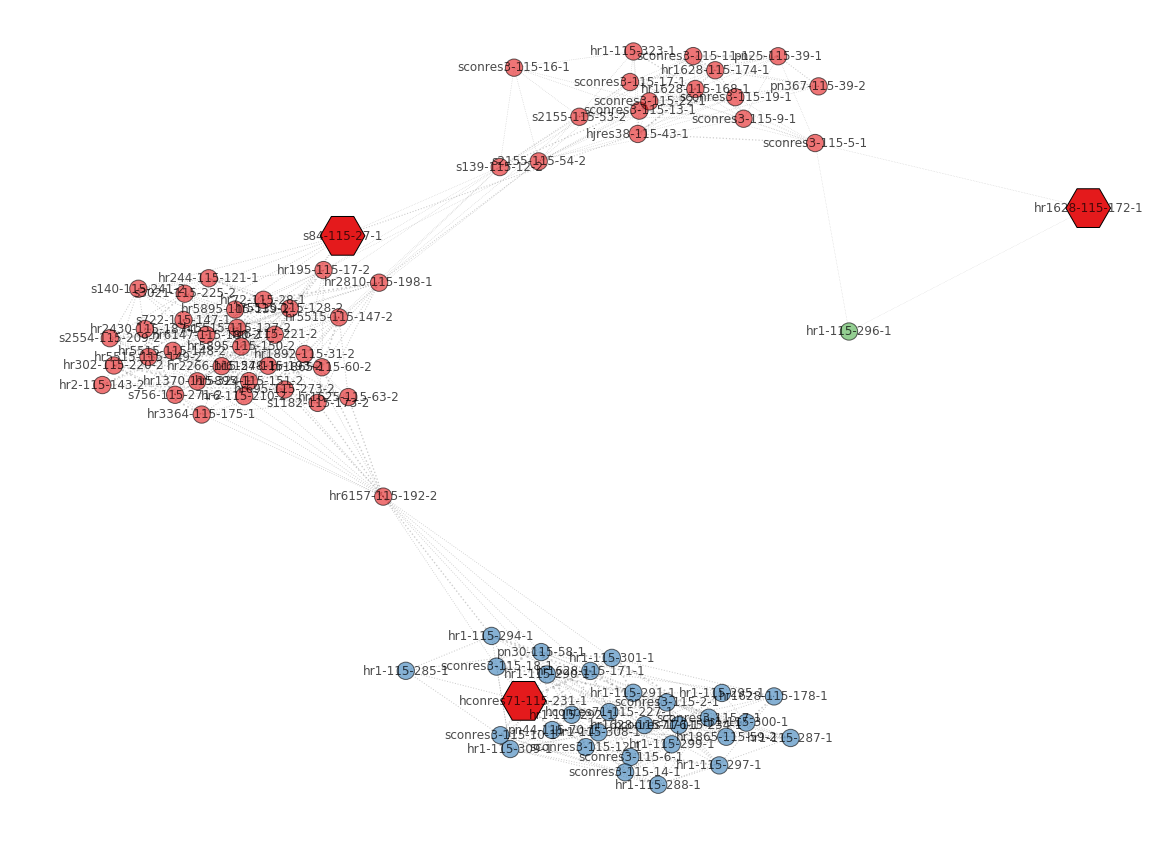

In [64]:
vote_selection = vote_repr.astype(int)
print(votes_train.iloc[:, vote_selection].columns.values)
plot_signal(G_bills.W.todense(), 
            clusters, 
            labels=votes_train.T.index, 
            scale=[0,9], 
            highlight_node=vote_selection,
            colormap=plt.get_cmap('Set1'))

## Embedding you in the graph

In [14]:
your_votes = [1,1,-1]
other_senators_vote = votes_train.values[:,vote_selection]

In [15]:
def compute_similarity(senator_votes):
    return euclidean_distance(senator_votes, your_votes)

similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote)
similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.5)

top_similar = similarity_vector.argsort()[-3:][::-1]
similar_senators = senators.iloc[top_similar]

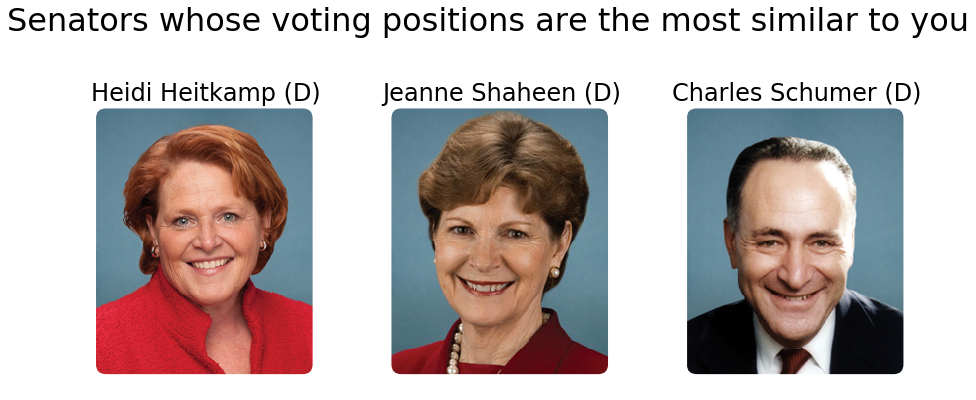

In [16]:
show_portraits(similar_senators)

In [17]:
new_columns = np.append(similarity_vector, 0)

n = len(adjacency)
new_adjacency = np.zeros((n+1, n+1))
new_adjacency[:n,:n] = adjacency
new_adjacency[n,:] = new_columns
new_adjacency[:,n] = new_columns

G_new = graphs.Graph(new_adjacency)
G_new.set_coordinates('spring', seed=2018)
G_new.compute_fourier_basis()
G_new.compute_laplacian()
G_new.compute_differential_operator()

new_labels = np.append(senators['name'].values, ['you'])

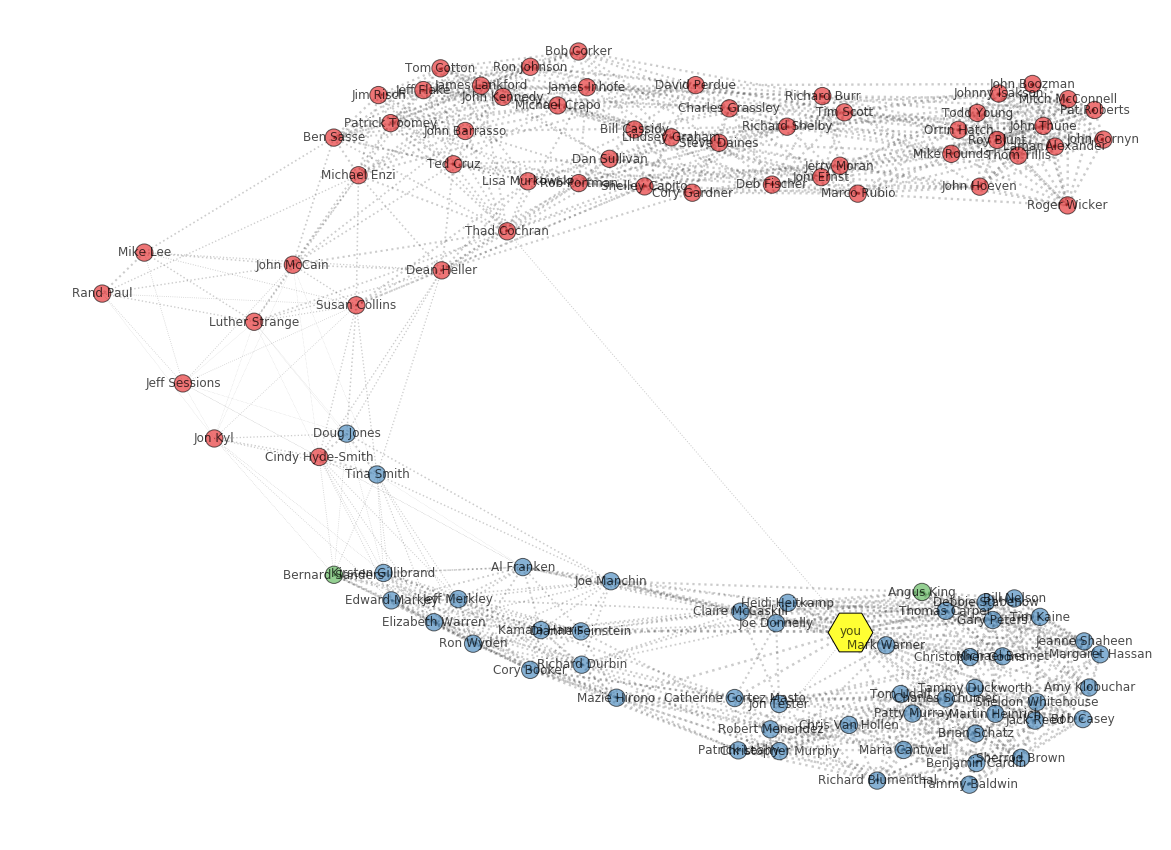

In [18]:
plot_signal(new_adjacency, np.append(numerical_labels, [0]), labels=new_labels, scale=[0,1], highlight_node=[105])

## Spectral analysis of the new adjacency matrix

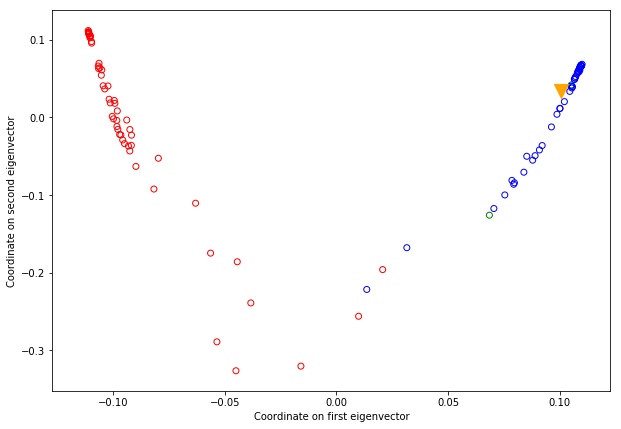

In [56]:
show_2D_embedding(G_new.U[:,1:3], senators_party)

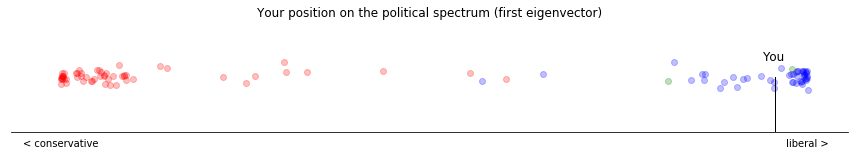

In [57]:
show_political_spectrum(embedding, n, colors, senators_party)

# Predicting votes based on votes from similar senators

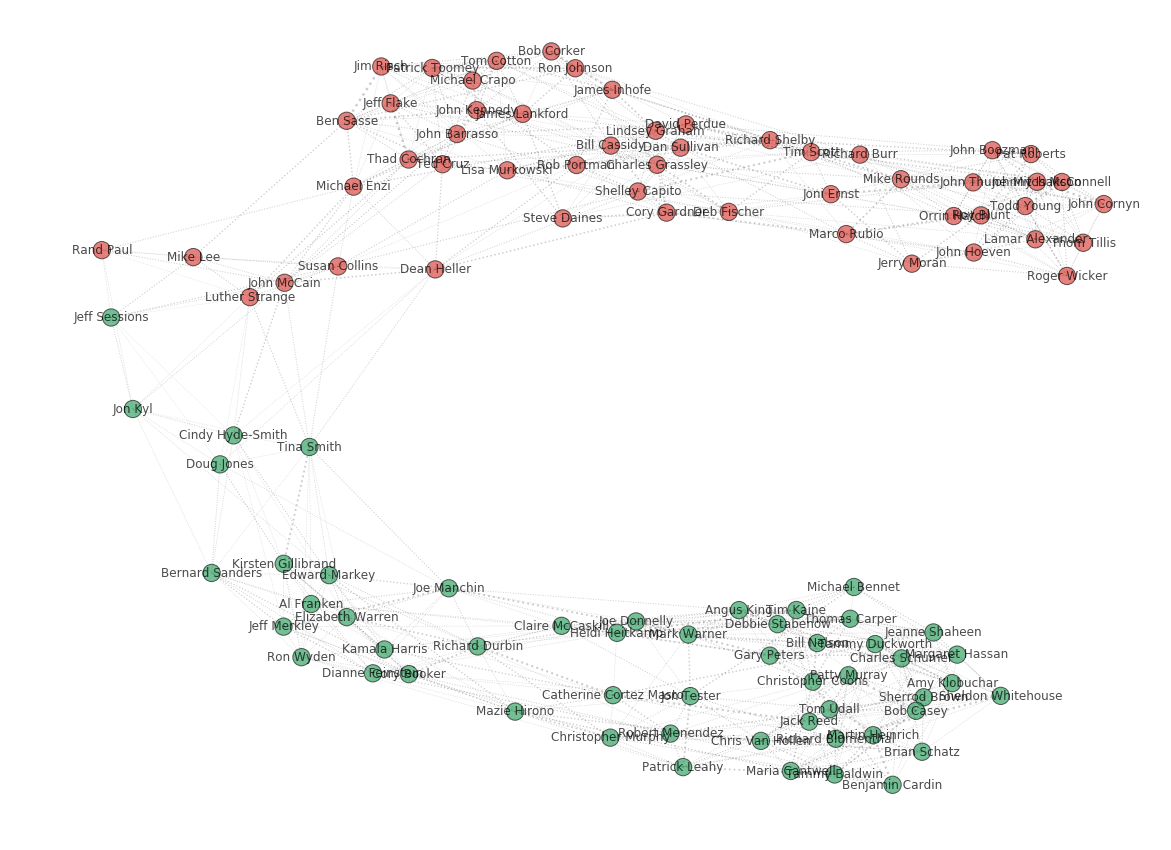

In [21]:
# Binarize labels
labels_bin = get_labels(votes_test.values[:,5], threshold=0)
n = len(labels_bin)

mn_ratio = 0.3 # Ratio of node labels to keep
m = int(mn_ratio * n)  # Number of measurements.
w = get_mask(n,m)

plot_signal(G.W.todense(), labels_bin, labels=senators['name'], scale=[-1.25,1.25], colormap=plt.get_cmap('RdYlGn'))

Error: 0.19518001458970666
Accuracy: 0.9904761904761905


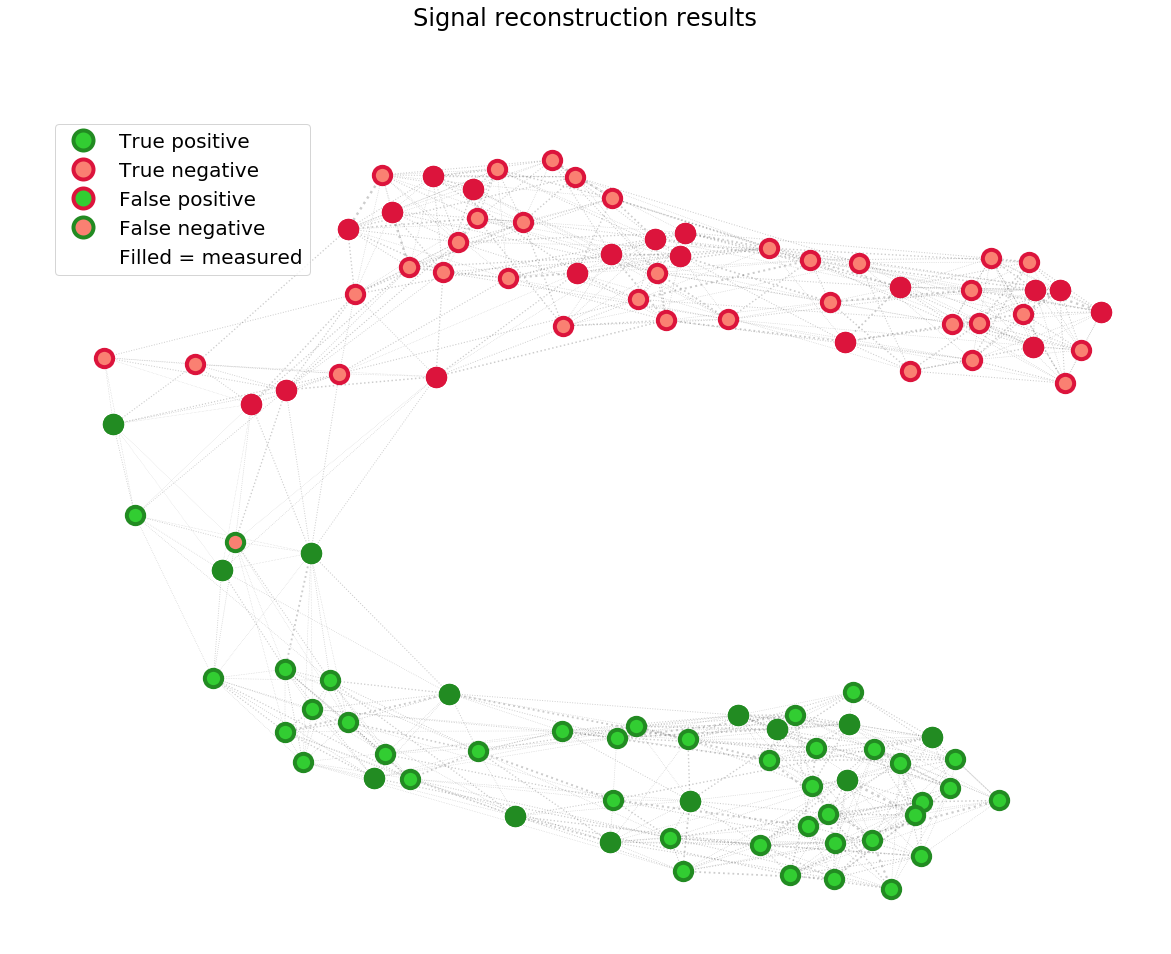

In [22]:
sol_2norm_bin =  reconstruct_signal(G,w,labels_bin)
plot_prediction(G, sol_2norm_bin, labels_bin, w)

print("Error: " + str(error(labels_bin, sol_2norm_bin)))
print("Accuracy: " + str(accuracy(labels_bin, sol_2norm_bin)))

# What about you ?


In [23]:
def predict_your_votes(G, positions, p=2, number_of_trials = 50):
    bill_votes = np.append(positions, 0)
    idx = np.argwhere(bill_votes!=0)
    w = np.append(np.ones(votes_test.shape[0]), [0])    
    
    sol_norm_min = np.zeros(n+1)
    
    for i in range(number_of_trials):
        sol_norm_min += graph_pnorm_interpolation(
            G.D,
            P_wrapper(w, bill_votes),
            np.random.randn(n+1),
            p,
            verbosity='NONE'
        ) / number_of_trials
        
    print(sol_norm_min[-1])
    
    return get_thresholded_values(sol_norm_min,0)

to_predict = 44 
sol_norm_min = predict_your_votes(G_new, votes['sconres3-115-19'])
print("On vote x you would have voted " + str(sol_norm_min[-1]))

KeyError: 'sconres3-115-19'

# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those that link the democratic and republican clusters

In [ ]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score  
    
parties = senators_party.copy()
parties[parties == 'I'] = 'D'
swing_senators = np.nonzero(swing_scores(np.asarray(G.W.todense()),parties) > 0.1)[0]
non_swing_senators = np.nonzero(swing_scores(G.W.todense(),parties) <= 0.1)[0]

print(senators['name'].iloc[swing_senators])

predict_and_compare(G, votes_test, swing_senators)

~85% accuracy. How does that compare to the same number of senators but picked at random ? 

In [ ]:
np.random.seed(2018)
random_senators = np.random.choice(len(senators), len(swing_senators), replace=False)
print(senators[['name', 'party']].iloc[random_senators])
predict_and_compare(G, votes_test, random_senators)